In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, loadtxt, pi, sqrt, sin, cos
import scipy
from scipy.stats import norm

In [7]:
#read the measured probing data
data = loadtxt('arbor_probing_data.txt')

<IPython.core.display.Javascript object>


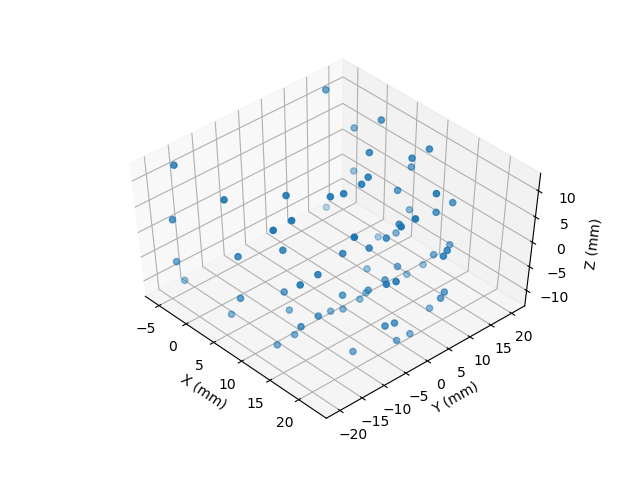

Text(0.5,0,'Z (mm)')

In [84]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

Axes3D = Axes3D  # pycharm auto import
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(data[:,0], data[:,1], data[:,2])

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')

In [55]:
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
a = data[:, 3]
c = data[:, 4]

def arbor_leastsq(vars, x, y, z, a, c):
    """calculate the distance from the spindle centerline vector to the contact point. 
    Distance is sum of arbor and probe ball radius"""
    
    ball_runout_y = vars[0]
    ball_runout_z = vars[1]
    radius = vars[2]
    spindle_centerline_offset = vars[3]
    x_offset = vars[4]
    y_home_offset = vars[5]
    z_home_offset = vars[6]
            
    a_angle_radians = (a/360.0)*2*pi

    ball_x = x + x_offset
    ball_y = y + y_home_offset + ball_runout_y*sin(a_angle_radians)
    ball_z = z + z_home_offset + ball_runout_z*cos(a_angle_radians)

    c_angle_radians = (c/360.0)*2*pi

    #find equation of the c-axis vector
    ui = -sin(c_angle_radians)
    uj = cos(c_angle_radians)
    uk = 0

    #coords of the spindle axis origin
    x0 = cos(c_angle_radians)*spindle_centerline_offset
    y0 = sin(c_angle_radians)*spindle_centerline_offset
    z0 = 0

    #find the closest point on the line
    point_x = x0 + ((ball_x-x0)*ui+(ball_y-y0)*uj+(ball_z-z0)*uk)*ui;
    point_y = y0 + ((ball_x-x0)*ui+(ball_y-y0)*uj+(ball_z-z0)*uk)*uj;
    point_z = z0 + ((ball_x-x0)*ui+(ball_y-y0)*uj+(ball_z-z0)*uk)*uk;

    error = np.sqrt(((point_x - ball_x)**2 + (point_y - ball_y)**2 + (point_z - ball_z)**2)) - radius

    return (error)

vars = np.array([0,0,0,0,0,0,0])

vars[0] = 0.0 #ball_runout_y
vars[1] = 0.0 #ball_runout_z
vars[2] = 0.0 #radius
vars[3] = 0.0 #spindle_centerline_offset
vars[4] = 0.0 #x_offset
vars[5] = 0.0 #y_home_offset
vars[6] = 0.0 #z_home_offset

p, success, infodict,mesg,ier  = scipy.optimize.leastsq(arbor_leastsq, vars, args=(x, y, z, a, c), full_output=1)

print('ball_runout_y \t\t\t=\t', p[0])
print('ball_runout_z \t\t\t=\t', p[1])
print('radius \t\t\t\t=\t', p[2])
print('spindle_centerline_offset \t=\t', p[3])
print('x_offset \t\t\t=\t', p[4])
print('y_home_offset \t\t\t=\t', p[5])
print('z_home_offset \t\t\t=\t', p[6])


ball_runout_y 			=	 0.012946725833152034
ball_runout_z 			=	 0.011393466237235628
radius 				=	 16.3537523042604
spindle_centerline_offset 	=	 -0.0801384807962915
x_offset 			=	 -0.011200799049105424
y_home_offset 			=	 -0.007434901636029629
z_home_offset 			=	 -0.013866373271930754


In [56]:
ball_runout = np.sqrt(p[0]**2 + p[1]**2)
print('ball runout = ', ball_runout, 'mm')
print('measured runout with dial = 0.024 mm')

ball runout =  0.017246123700641675 mm
measured runout with dial = 0.024 mm


<IPython.core.display.Javascript object>


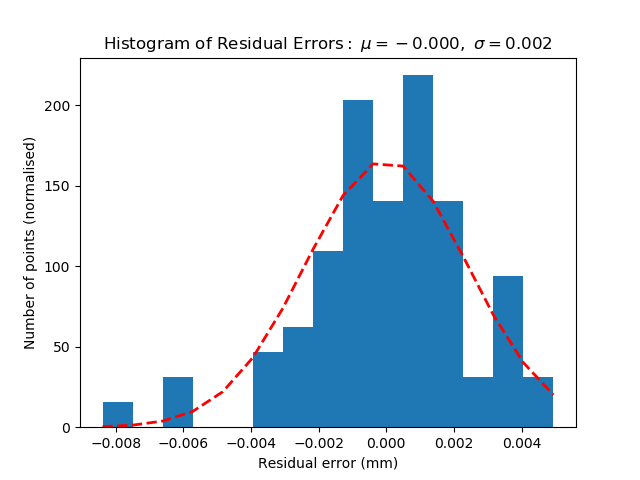

In [82]:
%matplotlib notebook

# best fit of data
(mu, sigma) = norm.fit(infodict['fvec'])

# the histogram of the data
n, bins, patches = plt.hist(infodict['fvec'], 15, density=True)

# add a 'best fit' line
y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Residual error (mm)')
plt.ylabel('Number of points (normalised)')
plt.title(r'$\mathrm{Histogram\ of\ Residual\ Errors:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

plt.show()

<IPython.core.display.Javascript object>


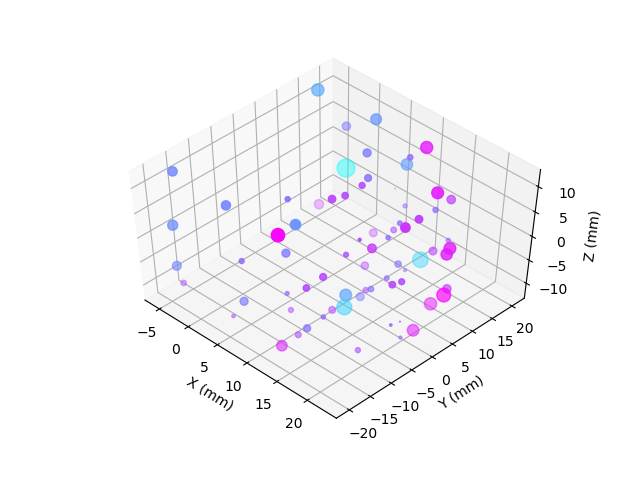

Text(0.5,0,'Z (mm)')

In [83]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

Axes3D = Axes3D  # pycharm auto import
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Normalised [0,1]
fvec_normalised = (infodict['fvec'] - np.min(infodict['fvec']))/np.ptp(infodict['fvec'])

ax.scatter3D(data[:,0], data[:,1], data[:,2], s = 20000*np.abs(infodict['fvec']), c = fvec_normalised, cmap = 'cool')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')